In [1]:
from google.colab import drive
import re
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
!cp -r /content/drive/MyDrive/Vision-HW3/* .
!cp -r vision-hw3/* .
!cp -r src/* .
!tar -xvf the3_data.tar.gz

Streaming output truncated to the last 5000 lines.
ceng483-f22-hw3-dataset/val/images/99.jpg
ceng483-f22-hw3-dataset/train/images/1175.jpg
ceng483-f22-hw3-dataset/train/images/2787.jpg
ceng483-f22-hw3-dataset/train/images/4295.jpg
ceng483-f22-hw3-dataset/train/images/1985.jpg
ceng483-f22-hw3-dataset/train/images/1669.jpg
ceng483-f22-hw3-dataset/train/images/4789.jpg
ceng483-f22-hw3-dataset/train/images/3987.jpg
ceng483-f22-hw3-dataset/val/images/1603.jpg
ceng483-f22-hw3-dataset/train/images/2087.jpg
ceng483-f22-hw3-dataset/train/images/2869.jpg
ceng483-f22-hw3-dataset/train/images/1285.jpg
ceng483-f22-hw3-dataset/train/images/4089.jpg
ceng483-f22-hw3-dataset/train/images/1779.jpg
ceng483-f22-hw3-dataset/train/images/3287.jpg
ceng483-f22-hw3-dataset/train/images/4899.jpg
ceng483-f22-hw3-dataset/val/images/1713.jpg
ceng483-f22-hw3-dataset/train/images/2197.jpg
ceng483-f22-hw3-dataset/train/images/2979.jpg
ceng483-f22-hw3-dataset/train/images/1395.jpg
ceng483-f22-hw3-dataset/train/images/

In [18]:
# ---- hyper-parameters ----
# You should tune these hyper-parameters using:
# (i) your reasoning and observations, 
# (ii) by tuning it on the validation set, using the techniques discussed in class.
# You definitely can add more hyper-parameters here.

# --- imports ---
import random
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import hw3utils
torch.multiprocessing.set_start_method('spawn', force=True)
# ---- utility functions -----
def get_loaders(batch_size,device):
    data_root = 'ceng483-f22-hw3-dataset' 
    train_set = hw3utils.HW3ImageFolder(root=os.path.join(data_root,'train'),device=device)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_set = hw3utils.HW3ImageFolder(root=os.path.join(data_root,'val'),device=device)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    # Note: you may later add test_loader to here.
    return train_loader, val_loader

In [4]:
# ---- ConvNet -----
class Net(nn.Module):
    def __init__(self, n_layers, n_kernels):
        super(Net, self).__init__()
        self.n_layers = n_layers
        self.n_kernels = n_kernels

        if n_layers == 1:
          self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
        elif n_layers == 2:
          self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=3, padding=1)
          self.conv2 = nn.Conv2d(in_channels=n_kernels, out_channels=3, kernel_size=3, padding=1)
        elif n_layers == 4:
          self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=3, padding=1)
          self.conv2 = nn.Conv2d(in_channels=n_kernels, out_channels=1, kernel_size=3, padding=1)
          self.conv3 = nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=3, padding=1)
          self.conv4 = nn.Conv2d(in_channels=n_kernels, out_channels=3, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()

    def forward(self, grayscale_image):
        # apply your network's layers in the following lines:
        if self.n_layers == 1:
          x = self.conv1(grayscale_image)
        
        elif self.n_layers == 2:
          x = self.relu(self.conv1(grayscale_image))
          x = self.conv2(x)

        elif self.n_layers == 4:
          x = self.relu(self.conv1(grayscale_image))
          x = self.relu(self.conv2(x))
          x = self.relu(self.conv3(x))
          x = self.conv4(x)
        
        return x

In [6]:
# seeding for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [7]:
def get_orig_range(arr):
  return ((arr - (-1)) * (1/2 * 255)).long()

In [9]:
def main(config_cnt=1):

  # Early stop patience parameter, if no improvement of delta
  # in last *patience* iterations, early stop the training...
  patience = 5
  delta = 1e-3

  # parameters as stated in the homework text
  batch_size = 16
  max_num_epoch = 100
  hps = {'lr':[1e-1, 1e-2, 1e-3, 1e-4], 'kernel_cnt':[2,4,8], 'n_layers':[1,2,4]}

  # ---- options ---- as provided
  DEVICE_ID = 'cuda:0' 
  LOG_DIR = 'checkpoints'
  IMG_DIR = 'img'
  VISUALIZE = False # set True to visualize input, prediction and the output from the last batch
  LOAD_CHKPT = False

  run_cnt = 0 # how many configs have been tried
  best_val_acc = 0 # holds best 12-margin validation accuracy
  best_config = "" # holds the config achieving best_val_acc

  # loop until desired amount of configs have been tried
  while(run_cnt < config_cnt):

    # randomly pick one from each parameter type
    lr = random.sample(hps['lr'], 1)[0]
    kc = random.sample(hps['kernel_cnt'], 1)[0]
    num_l = random.sample(hps['n_layers'], 1)[0]
    
    run_cnt += 1
    # ---- training code -----
    device = torch.device(DEVICE_ID)
    print('device: ' + str(device))
    net = Net(num_l, kc).to(device=device) # initialize network with parameters
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=lr)
    train_loader, val_loader = get_loaders(batch_size,device)

    if LOAD_CHKPT:
      print('loading the model from the checkpoint')
      net.load_state_dict(os.path.join(LOG_DIR,'checkpoint.pt'))
    
    min_val_loss = np.iinfo('uint32').max
    curr_patience = 0

    for epoch in range(max_num_epoch):  

      if curr_patience >= patience:
        print(f"No significant improvement since last {patience} iterations, early stopping at epoch: {epoch+1}...")
        break
      
      running_loss = 0.0 # training loss of the network
      train_total = 0
      for iteri, data in enumerate(train_loader, 0):
        inputs, targets = data
        optimizer.zero_grad()
        preds = net(inputs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_total += inputs.shape[0]
      
      # validation run at each epoch
      net.eval()
      val_loss = 0.0
      val_total = 0
      cur_acc = 0.0
      with torch.no_grad():
        for iteri, data in enumerate(val_loader, 0):
          val_inputs, val_targets = data
          val_preds = net(val_inputs)
          _loss = criterion(val_preds, val_targets)
          val_loss += _loss.item()
          val_total += val_inputs.shape[0]

          # convert prediction and label to its original range
          _val_preds = get_orig_range(val_preds)
          _val_targets = get_orig_range(val_targets)
          cur_acc += (torch.abs(_val_targets - _val_preds) < 12).sum()
      
      cur_acc /= (val_total*80*80*3)
      
      # if at least delta amount of improvement compared
      # to the current best, then set run patience to zero
      if (val_loss / val_total + delta) < min_val_loss:
        min_val_loss = val_loss / val_total
        curr_patience = 0
      else:
        curr_patience += 1
      
      # update the best accuracy if current config is better
      if cur_acc >= best_val_acc:
        best_val_acc = cur_acc
        best_config = f"LR{lr}_KernelCount{kc}_ConvLayerCount_{num_l}_Epoch{epoch}"

      print(f'Epoch: {epoch+1}, Train Loss: {running_loss / train_total}, Valid Loss: {val_loss / val_total}, 12-Margin Accuracy: {cur_acc}')
      print('Saving the model, end of epoch %d' % (epoch+1))
      if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
      torch.save(net.state_dict(), os.path.join(LOG_DIR,'checkpoint.pt'))
      if not os.path.exists(IMG_DIR):
        os.makedirs(IMG_DIR)
      hw3utils.visualize_batch(val_inputs,val_preds,val_targets,os.path.join(IMG_DIR,f'LR{lr}_KernelCount{kc}_ConvLayerCount_{num_l}_Epoch{epoch+1}.png'))
    print(f'Finished Training Config: LR: {lr}, Kernel Count: {kc}, Conv. Layer Count: {num_l}')

  print(f"Best config {best_config} reached 12-margin accuracy of: {best_val_acc}")

device: cuda:0
Epoch: 1, Train Loss: 0.017259689116091805, Valid Loss: 0.013648682765662671, 12-Margin Accuracy: 0.13258302211761475
Saving the model, end of epoch 1
Epoch: 2, Train Loss: 0.01153335118861085, Valid Loss: 0.009173140723258257, 12-Margin Accuracy: 0.16140085458755493
Saving the model, end of epoch 2
Epoch: 3, Train Loss: 0.0077940567827324845, Valid Loss: 0.006253104906529188, 12-Margin Accuracy: 0.19623921811580658
Saving the model, end of epoch 3
Epoch: 4, Train Loss: 0.00535416026230789, Valid Loss: 0.004346303950995207, 12-Margin Accuracy: 0.23765622079372406
Saving the model, end of epoch 4
Epoch: 5, Train Loss: 0.003759413095736022, Valid Loss: 0.0031013602800667285, 12-Margin Accuracy: 0.28607863187789917
Saving the model, end of epoch 5
Epoch: 6, Train Loss: 0.002718268843936434, Valid Loss: 0.002287888264283538, 12-Margin Accuracy: 0.34125298261642456
Saving the model, end of epoch 6
Epoch: 7, Train Loss: 0.0020369786521096966, Valid Loss: 0.0017568242717534305,

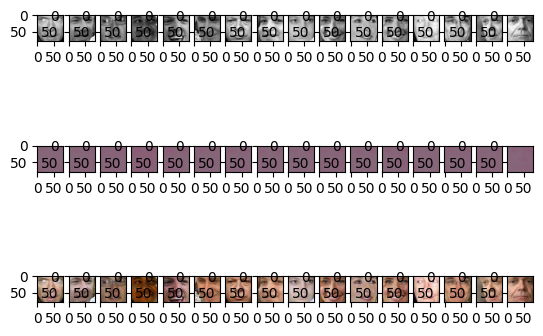

In [10]:
# out of 36 possible configs, we are
# being generous and trying out 15

if __name__ == "__main__":
  main(config_cnt=15)

In [2]:
# ---- FurtherNet -----
class FurtherNet(nn.Module):
    def __init__(self, batchnorm=False, hyptan=False, sixteen=False, separable=False, group=False):
        super(FurtherNet, self).__init__()

        # parameters from the best config as stated above....
        self.n_layers = 2
        self.n_kernels = 4
        self.batchnorm = batchnorm
        self.hyptan = hyptan
        self.sixteen = sixteen
        self.separable = separable
        self.group = group

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.n_kernels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.n_kernels, out_channels=3, kernel_size=3, padding=1)
        
        self.conv1_sixt = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2_sixt = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)

        # out_channels=1*16 since 16 showed improvement
        self.sep_dep1 = nn.Conv2d(in_channels=1, out_channels=1*16, kernel_size=3, padding=1, groups=1)
        self.sep_point1 = nn.Conv2d(in_channels=1*16, out_channels=3, kernel_size=1)

        # out_channels=3*16 since 16 showed improvement and
        # both in_channels and out_channels must be divisible
        # by number of groups, which can only be 3 other than
        # trivial 1...
        self.group_conv1 = nn.Conv2d(in_channels=1, out_channels=3*16, kernel_size=3, padding=1, groups=1)
        self.group_conv2 = nn.Conv2d(in_channels=3*16, out_channels=3, kernel_size=3, padding=1, groups=3)
        
        self.bn = nn.BatchNorm2d(num_features=self.n_kernels)
        self.bn_sixt = nn.BatchNorm2d(num_features=16)
        self.bn_group = nn.BatchNorm2d(num_features=3*16)
        self.tanh = torch.tanh
        self.relu = nn.ReLU()

    def forward(self, grayscale_image):
        # apply your network's layers in the following lines:

        # trying batchnormalization...
        if self.batchnorm and not self.sixteen and not self.separable and not self.group:
          x = self.relu(self.bn(self.conv1(grayscale_image)))
          x = self.conv2(x)
        
        # trying 16 channels option...
        elif self.sixteen and not self.separable and not self.group:
          if self.batchnorm:
            x = self.relu(self.bn_sixt(self.conv1_sixt(grayscale_image)))
            x = self.conv2_sixt(x)
          else:
            x = self.relu(self.conv1_sixt(grayscale_image))
            x = self.conv2_sixt(x)

        # trying separable...
        # no need to consider an additional case for no sixteen since it improved...
        elif self.separable and not self.group:
          if self.batchnorm:
            x = self.relu(self.bn_sixt(self.sep_dep1(grayscale_image)))
            x = self.sep_point1(x)
          else:
            x = self.relu(self.sep_dep1(grayscale_image))
            x = self.sep_point1(x)

        # trying group conv...
        # no need to consider an additional case for no sixteen since it improved...
        elif self.group:
          if self.batchnorm:
            x = self.relu(self.bn_group(self.group_conv1(grayscale_image)))
            x = self.group_conv2(x)
          else:
            x = self.relu(self.group_conv1(grayscale_image))
            x = self.group_conv2(x)
        
        # regular case...
        else:
          x = self.relu(self.conv1(grayscale_image))
          x = self.conv2(x)
        
        # apply hyperbolic tangent at the end if true
        if self.hyptan:
          x = self.tanh(x)
        
        return x

In [21]:
def further_main(config_cnt=1, batchnorm=False, hyptan=False, sixteen=False, separable=False, group=False):

  # Early stop patience parameter, if no improvement of delta
  # in last *patience* iterations, early stop the training...
  # increased patience as this is the best config
  patience = 15
  delta = 1e-3

  # parameters as stated in the homework text, only the best LR this time
  batch_size = 16
  max_num_epoch = 100
  hps = {'lr':[1e-1]}

  # ---- options ---- as provided
  DEVICE_ID = 'cuda:0' 
  LOG_DIR = 'checkpoints'
  IMG_DIR = 'img'
  VISUALIZE = False # set True to visualize input, prediction and the output from the last batch
  LOAD_CHKPT = False

  run_cnt = 0 # how many configs have been tried
  best_val_acc = 0 # holds best 12-margin validation accuracy
  best_config = "" # holds the config achieving best_val_acc

  # loop until desired amount of configs have been tried
  while(run_cnt < config_cnt):

    # can only pick the best lr as given above...
    lr = random.sample(hps['lr'], 1)[0]
    
    run_cnt += 1
    # ---- training code -----
    device = torch.device(DEVICE_ID)
    print('device: ' + str(device))
    net = FurtherNet(batchnorm=batchnorm, hyptan=hyptan, sixteen=sixteen, separable=separable, group=group).to(device=device) # initialize network with parameters
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=lr)
    train_loader, val_loader = get_loaders(batch_size,device)

    if LOAD_CHKPT:
      print('loading the model from the checkpoint')
      net.load_state_dict(os.path.join(LOG_DIR,'checkpoint.pt'))
    
    min_val_loss = np.iinfo('uint32').max
    curr_patience = 0

    for epoch in range(max_num_epoch):  

      if curr_patience >= patience:
        print(f"No significant improvement since last {patience} iterations, early stopping at epoch: {epoch+1}...")
        break
      
      running_loss = 0.0 # training loss of the network
      train_total = 0
      for iteri, data in enumerate(train_loader, 0):
        inputs, targets = data
        optimizer.zero_grad()
        preds = net(inputs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_total += inputs.shape[0]
      
      # validation run at each epoch
      net.eval()
      val_loss = 0.0
      val_total = 0
      cur_acc = 0.0
      with torch.no_grad():
        for iteri, data in enumerate(val_loader, 0):
          val_inputs, val_targets = data
          val_preds = net(val_inputs)
          _loss = criterion(val_preds, val_targets)
          val_loss += _loss.item()
          val_total += val_inputs.shape[0]

          # convert prediction and label to its original range
          _val_preds = get_orig_range(val_preds)
          _val_targets = get_orig_range(val_targets)
          cur_acc += (torch.abs(_val_targets - _val_preds) < 12).sum()
      
      cur_acc /= (val_total*80*80*3)
      
      # if at least delta amount of improvement compared
      # to the current best, then set run patience to zero
      if (val_loss / val_total + delta) < min_val_loss:
        min_val_loss = val_loss / val_total
        curr_patience = 0
      else:
        curr_patience += 1
      
      # update the best accuracy if current config is better
      # batchnorm=False, hyptan=False, sixteen=False, separable=False, group=False
      if cur_acc >= best_val_acc:
        best_val_acc = cur_acc
        best_config = f"BN:{batchnorm}_Tanh:{hyptan}_isSixteen:{sixteen}_Separable:{separable}_Group:{group}_Epoch{epoch+1}"

      print(f'Epoch: {epoch+1}, Train Loss: {running_loss / train_total}, Valid Loss: {val_loss / val_total}, 12-Margin Accuracy: {cur_acc}')
      print('Saving the model, end of epoch %d' % (epoch+1))
      if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
      torch.save(net.state_dict(), os.path.join(LOG_DIR,'checkpoint.pt'))
      hw3utils.visualize_batch(val_inputs,val_preds,val_targets,os.path.join(IMG_DIR,f'BN:{batchnorm}_Tanh:{hyptan}_isSixteen:{sixteen}_Separable:{separable}_Group:{group}_Epoch{epoch+1}.png'))
    print(f'f"BN:{batchnorm}_Tanh:{hyptan}_isSixteen:{sixteen}_Separable:{separable}_Group:{group}_Epoch{epoch+1}"')

  print(f"Best config {best_config} reached 12-margin accuracy of: {best_val_acc}")

device: cuda:0
Epoch: 1, Train Loss: 0.001184535403697759, Valid Loss: 0.0008736699353903532, 12-Margin Accuracy: 0.6171575784683228
Saving the model, end of epoch 1
Epoch: 2, Train Loss: 0.0006720978829810808, Valid Loss: 0.0006564941753167659, 12-Margin Accuracy: 0.7052068710327148
Saving the model, end of epoch 2
Epoch: 3, Train Loss: 0.0006220702879343884, Valid Loss: 0.0006240286370739341, 12-Margin Accuracy: 0.7153998017311096
Saving the model, end of epoch 3
Epoch: 4, Train Loss: 0.0005943282177551487, Valid Loss: 0.0005899164818692952, 12-Margin Accuracy: 0.7294067144393921
Saving the model, end of epoch 4
Epoch: 5, Train Loss: 0.0005798181828980719, Valid Loss: 0.0005823637896683067, 12-Margin Accuracy: 0.7322838306427002
Saving the model, end of epoch 5
Epoch: 6, Train Loss: 0.000568167092321432, Valid Loss: 0.0005687142761889846, 12-Margin Accuracy: 0.73787921667099
Saving the model, end of epoch 6
Epoch: 7, Train Loss: 0.0005612863279682437, Valid Loss: 0.000564323627855628

<Figure size 432x288 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

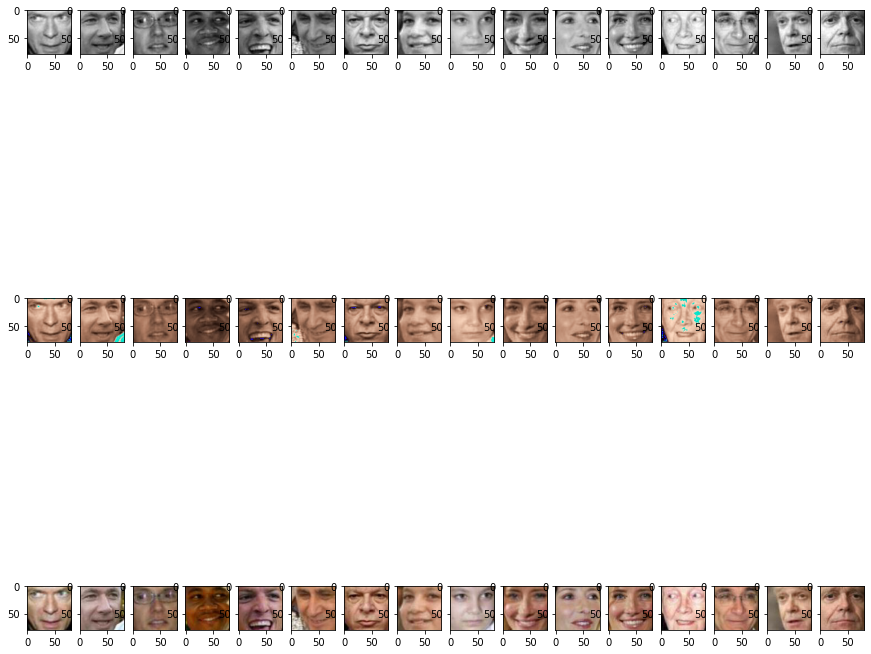

In [ ]:
# trying out with batch normalization, patience is significantly increased...
further_main(config_cnt=1, batchnorm=True)

device: cuda:0
Epoch: 1, Train Loss: 0.001093042646235846, Valid Loss: 0.0006977689387276768, 12-Margin Accuracy: 0.6909186840057373
Saving the model, end of epoch 1
Epoch: 2, Train Loss: 0.0006618260999464007, Valid Loss: 0.0006440552389249206, 12-Margin Accuracy: 0.7090798020362854
Saving the model, end of epoch 2
Epoch: 3, Train Loss: 0.0006305390920127256, Valid Loss: 0.0006285598792601377, 12-Margin Accuracy: 0.7089239358901978
Saving the model, end of epoch 3
Epoch: 4, Train Loss: 0.0006109032241921441, Valid Loss: 0.0006281669125892222, 12-Margin Accuracy: 0.7128987312316895
Saving the model, end of epoch 4
Epoch: 5, Train Loss: 0.0005982879111072143, Valid Loss: 0.000614580798195675, 12-Margin Accuracy: 0.7160844206809998
Saving the model, end of epoch 5
Epoch: 6, Train Loss: 0.0005873165937344317, Valid Loss: 0.0005975810100790113, 12-Margin Accuracy: 0.7202467918395996
Saving the model, end of epoch 6
Epoch: 7, Train Loss: 0.0005818551918947978, Valid Loss: 0.0005907750183250

<Figure size 432x288 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

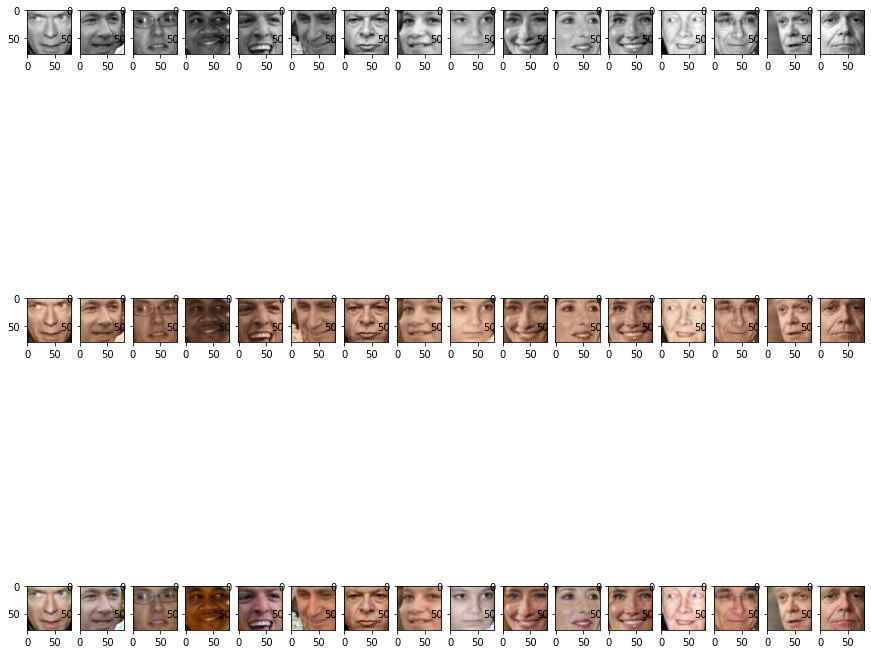

In [ ]:
# trying out with tanh and batchnorm since batchnorm improved, patience is significantly increased...
further_main(config_cnt=1, batchnorm=True, hyptan=True)

device: cuda:0
Epoch: 1, Train Loss: 0.0024874515450077042, Valid Loss: 0.0008680245443247258, 12-Margin Accuracy: 0.6114299297332764
Saving the model, end of epoch 1
Epoch: 2, Train Loss: 0.0006274140745898981, Valid Loss: 0.0005922702185343951, 12-Margin Accuracy: 0.7245864272117615
Saving the model, end of epoch 2
Epoch: 3, Train Loss: 0.0005744744559284021, Valid Loss: 0.0005642222943715752, 12-Margin Accuracy: 0.7402167916297913
Saving the model, end of epoch 3
Epoch: 4, Train Loss: 0.0005608834676374509, Valid Loss: 0.0005620795665308833, 12-Margin Accuracy: 0.7394915819168091
Saving the model, end of epoch 4
Epoch: 5, Train Loss: 0.0005536510886010278, Valid Loss: 0.0005407874207012355, 12-Margin Accuracy: 0.7472527027130127
Saving the model, end of epoch 5
Epoch: 6, Train Loss: 0.0005482595718963531, Valid Loss: 0.0006469764052890241, 12-Margin Accuracy: 0.7146963477134705
Saving the model, end of epoch 6
Epoch: 7, Train Loss: 0.0005431759533958599, Valid Loss: 0.00055944122537

<Figure size 432x288 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

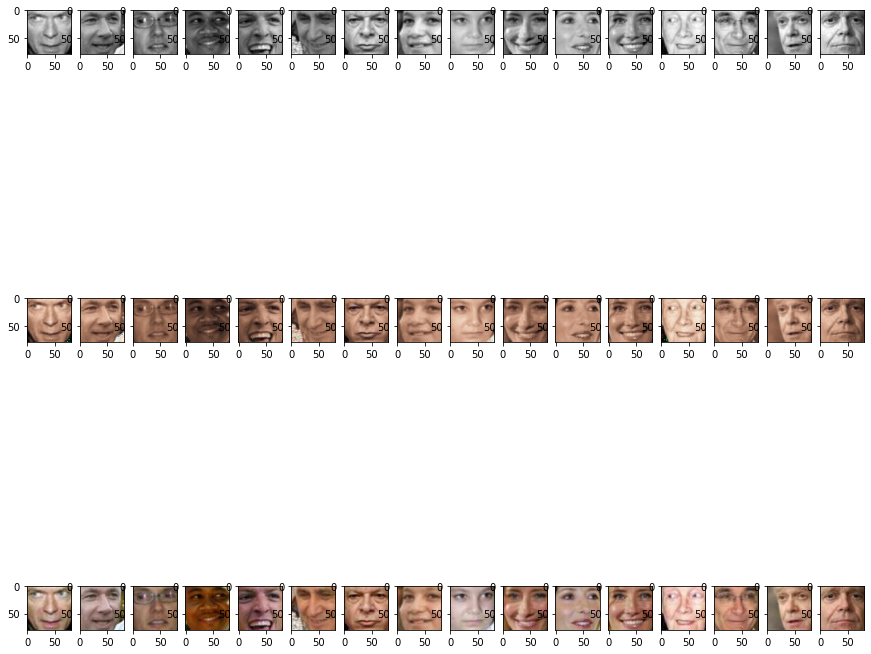

In [ ]:
# trying out with 16 channels, without tanh and with batchnorm since only batchnorm improved, patience is significantly increased...
further_main(config_cnt=1, batchnorm=True, hyptan=False, sixteen=True)

device: cuda:0
Epoch: 1, Train Loss: 0.0012366320893922298, Valid Loss: 0.000645093088503927, 12-Margin Accuracy: 0.7035151124000549
Saving the model, end of epoch 1
Epoch: 2, Train Loss: 0.0005894568162156245, Valid Loss: 0.000576410171110183, 12-Margin Accuracy: 0.731501579284668
Saving the model, end of epoch 2
Epoch: 3, Train Loss: 0.0005626633840225155, Valid Loss: 0.000562313650501892, 12-Margin Accuracy: 0.7380863428115845
Saving the model, end of epoch 3
Epoch: 4, Train Loss: 0.0005503509156785829, Valid Loss: 0.000553013080265373, 12-Margin Accuracy: 0.7417905926704407
Saving the model, end of epoch 4
Epoch: 5, Train Loss: 0.0005447107895730531, Valid Loss: 0.0005511487270705402, 12-Margin Accuracy: 0.7431473135948181
Saving the model, end of epoch 5
Epoch: 6, Train Loss: 0.0005418028949892681, Valid Loss: 0.0005437345337122679, 12-Margin Accuracy: 0.745673418045044
Saving the model, end of epoch 6
Epoch: 7, Train Loss: 0.0005381627831815887, Valid Loss: 0.0005434955046512187,

<Figure size 432x288 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

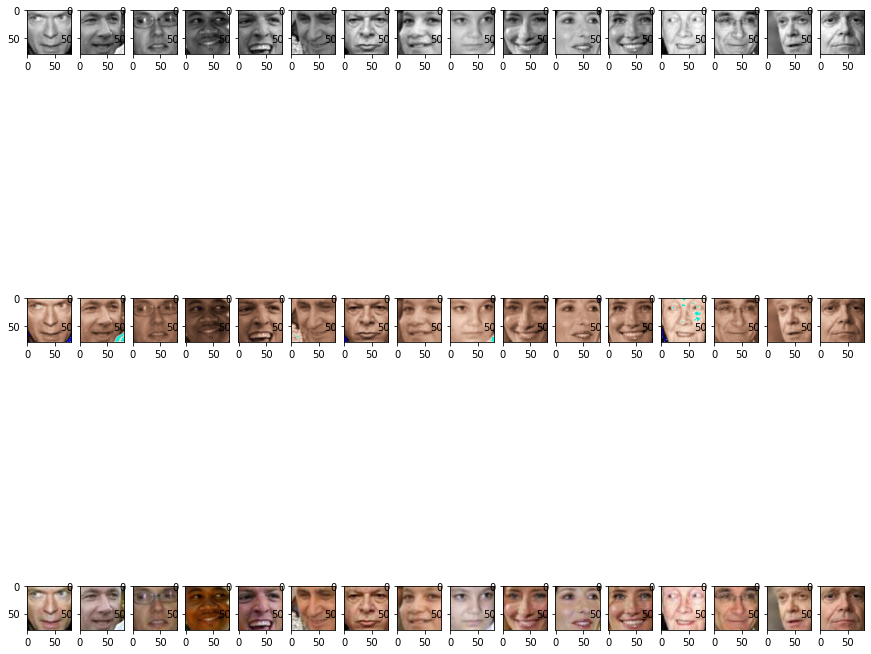

In [ ]:
# trying out with separable conv. layers, 16 channels, without tanh and with batchnorm since batchnorm & 16 improved, patience is significantly increased...
further_main(config_cnt=1, batchnorm=True, hyptan=False, sixteen=True, separable=True)

device: cuda:0
Epoch: 1, Train Loss: 0.003204092914877332, Valid Loss: 0.0016057435115799307, 12-Margin Accuracy: 0.4465174376964569
Saving the model, end of epoch 1
Epoch: 2, Train Loss: 0.0006496653425786775, Valid Loss: 0.0005833875220268965, 12-Margin Accuracy: 0.7295407056808472
Saving the model, end of epoch 2
Epoch: 3, Train Loss: 0.0005900301340907079, Valid Loss: 0.0005808158183936029, 12-Margin Accuracy: 0.7324227094650269
Saving the model, end of epoch 3
Epoch: 4, Train Loss: 0.000578762871697262, Valid Loss: 0.0006434477511793375, 12-Margin Accuracy: 0.7112913727760315
Saving the model, end of epoch 4
Epoch: 5, Train Loss: 0.0005667265259709758, Valid Loss: 0.0006289751005824656, 12-Margin Accuracy: 0.6997004151344299
Saving the model, end of epoch 5
Epoch: 6, Train Loss: 0.0005576425434794694, Valid Loss: 0.0005861858599819243, 12-Margin Accuracy: 0.7244015336036682
Saving the model, end of epoch 6
Epoch: 7, Train Loss: 0.0005515919193041441, Valid Loss: 0.0005537081090733

<Figure size 432x288 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

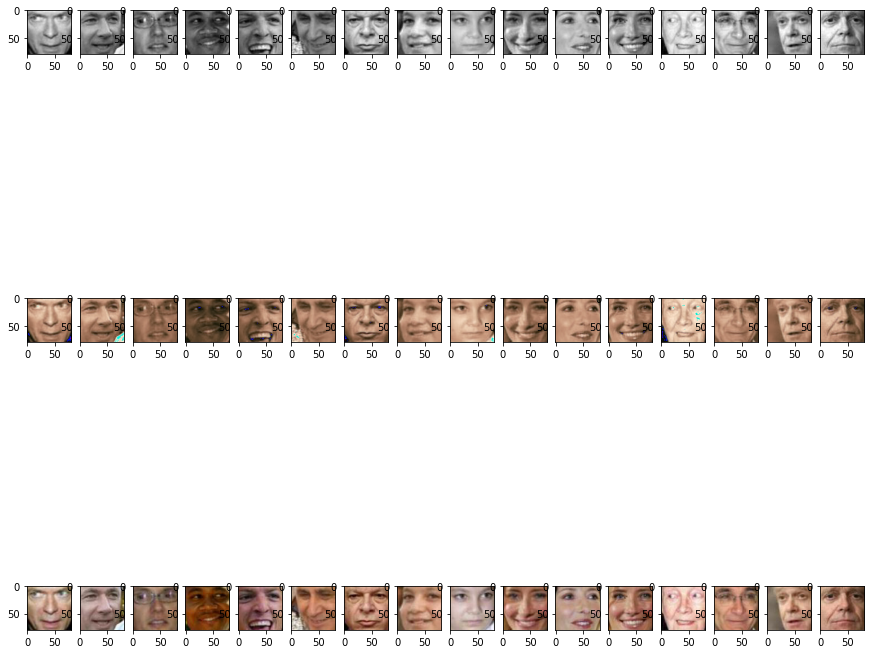

In [ ]:
# trying out with group conv. layers, 16 channels, without tanh and with batchnorm since batchnorm & 16 improved, patience is significantly increased...
further_main(config_cnt=1, batchnorm=True, hyptan=False, sixteen=True, separable=False, group=True)

In [1]:
# ---- hyper-parameters ----
# You should tune these hyper-parameters using:
# (i) your reasoning and observations, 
# (ii) by tuning it on the validation set, using the techniques discussed in class.
# You definitely can add more hyper-parameters here.

# --- imports ---
import random
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import hw3utils

torch.multiprocessing.set_start_method('spawn', force=True)
# ---- utility functions -----
def get_loaders(batch_size,device):
    data_root = 'ceng483-f22-hw3-dataset' 
    train_set = hw3utils.HW3ImageFolder(root=os.path.join(data_root,'train'),device=device)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_set = hw3utils.HW3ImageFolder(root=os.path.join(data_root,'val'),device=device)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    # Note: you may later add test_loader to here.
    return train_loader, val_loader

# seeding for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

def get_orig_range(arr):
  return ((arr - (-1)) * (1/2 * 255)).long()

# ---- FurtherNet -----
class BestNet(nn.Module):
    def __init__(self):
        super(BestNet, self).__init__()

        # parameters from the best config as stated above....
        self.n_layers = 2
        self.n_kernels = 4

        # The best config uses batch normalization and 16 intermediate channels
        
        self.conv1_sixt = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2_sixt = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)
        
        self.bn_sixt = nn.BatchNorm2d(num_features=16)
        self.relu = nn.ReLU()

    def forward(self, grayscale_image):
        # apply your network's layers in the following lines:

        x = self.relu(self.bn_sixt(self.conv1_sixt(grayscale_image)))
        x = self.conv2_sixt(x)

        return x

def best_main(plot = False, save = False):

  # Early stop patience parameter, if no improvement of delta
  # in last *patience* iterations, early stop the training...
  # increased patience as this is the best config
  patience = 15
  delta = 1e-3

  # parameters as stated in the homework text, only the best LR this time
  batch_size = 16
  max_num_epoch = 100
  lr = 1e-1

  # ---- options ---- as provided
  DEVICE_ID = 'cuda:0' 
  LOG_DIR = 'checkpoints'
  IMG_DIR = 'img'
  VISUALIZE = False # set True to visualize input, prediction and the output from the last batch
  LOAD_CHKPT = False

  # Store the training and validation losses per epoch for plotting
  training_losses = []
  validation_losses = []
  last_epoch_num = 0

  # Store the last batch for image printing
  last_pred = []
  last_actual = []
  
  
  # ---- training code -----
  device = torch.device(DEVICE_ID)
  print('device: ' + str(device))
  net = BestNet().to(device=device) # initialize network with parameters
  criterion = nn.MSELoss()
  optimizer = optim.SGD(net.parameters(), lr=lr)
  train_loader, val_loader = get_loaders(batch_size,device)

  if LOAD_CHKPT:
    print('loading the model from the checkpoint')
    net.load_state_dict(os.path.join(LOG_DIR,'checkpoint.pt'))
  
  min_val_loss = np.iinfo('uint32').max
  curr_patience = 0
  best_accuracy = 0
  best_epoch_num = 0

  for epoch in range(max_num_epoch):  

    if curr_patience >= patience:
      print(f"No significant improvement since last {patience} iterations, early stopping at epoch: {epoch+1}...")
      break
    
    running_loss = 0.0 # training loss of the network
    train_total = 0
    for iteri, data in enumerate(train_loader, 0):
      inputs, targets = data
      optimizer.zero_grad()
      preds = net(inputs)
      loss = criterion(preds, targets)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      train_total += inputs.shape[0]
    
    # validation run at each epoch
    net.eval()
    val_loss = 0.0
    val_total = 0
    cur_acc = 0.0
    curr_12_margin_error = 0.0
    with torch.no_grad():
      for iteri, data in enumerate(val_loader, 0):
        val_inputs, val_targets = data
        val_preds = net(val_inputs)
        _loss = criterion(val_preds, val_targets)
        val_loss += _loss.item()
        val_total += val_inputs.shape[0]

        # convert prediction and label to its original range
        _val_preds = get_orig_range(val_preds)
        _val_targets = get_orig_range(val_targets)
        cur_acc += (torch.abs(_val_targets - _val_preds) < 12).sum()
        curr_12_margin_error += (torch.abs(_val_targets - _val_preds) >= 12).sum()
    
    cur_acc /= (val_total*80*80*3)
    curr_12_margin_error /= (val_total*80*80*3)
    print(f'valid error: {curr_12_margin_error}')
    validation_losses.append(curr_12_margin_error.item())
    
    # if at least delta amount of improvement compared
    # to the current best, then set run patience to zero
    if (val_loss / val_total + delta) < min_val_loss:
      min_val_loss = val_loss / val_total
      curr_patience = 0
    else:
      curr_patience += 1

    training_losses.append(running_loss / train_total)
    last_epoch_num = epoch + 1
    if cur_acc - delta > best_accuracy:
      best_accuracy = cur_acc
      best_epoch_num = epoch + 1

    print(f'Epoch: {epoch+1}, Train Loss: {running_loss / train_total}, Valid Loss: {val_loss / val_total}, 12-Margin Accuracy: {cur_acc}')
    print('Saving the model, end of epoch %d' % (epoch+1))
    if not os.path.exists(LOG_DIR):
      os.makedirs(LOG_DIR)
    if not os.path.exists(IMG_DIR):
      os.makedirs(IMG_DIR)
    torch.save(net.state_dict(), os.path.join(LOG_DIR,'checkpoint.pt'))
    last_pred = val_preds
    last_actual = val_targets
    hw3utils.visualize_batch(val_inputs,val_preds,val_targets,os.path.join(IMG_DIR,f'Best_Config_Epoch{epoch+1}.png'))

  print(f'Best epoch was {best_epoch_num} with an accuracy {best_accuracy}')

  if plot:
    fig_train_loss, ax_train_loss = plt.subplots()
    ax_train_loss.set_xlabel('Epochs')
    ax_train_loss.set_ylabel('Training loss')
    ax_train_loss.plot(range(1, last_epoch_num + 1), training_losses)

    fig_val_loss, ax_val_loss = plt.subplots()
    ax_val_loss.set_xlabel('Epochs')
    ax_val_loss.set_ylabel('Validation loss')
    ax_val_loss.plot(range(1, last_epoch_num + 1), validation_losses)

  if save:
    for i in range(10):
      predicted_image = last_pred[i]
      actual_image = last_actual[i]
      hw3utils.save_tensor_as_image(predicted_image, f'Predicted_{i + 1}')
      hw3utils.save_tensor_as_image(actual_image, f'Actual_{i + 1}')


device: cuda:0
valid error: 0.3494532108306885
Epoch: 1, Train Loss: 0.0032607856961933703, Valid Loss: 0.0007437987611629068, 12-Margin Accuracy: 0.6505465507507324
Saving the model, end of epoch 1
valid error: 0.2671160399913788
Epoch: 2, Train Loss: 0.0006030228134588084, Valid Loss: 0.0005728307499084621, 12-Margin Accuracy: 0.7328837513923645
Saving the model, end of epoch 2
Best epoch was 2 with an accuracy 0.7328837513923645


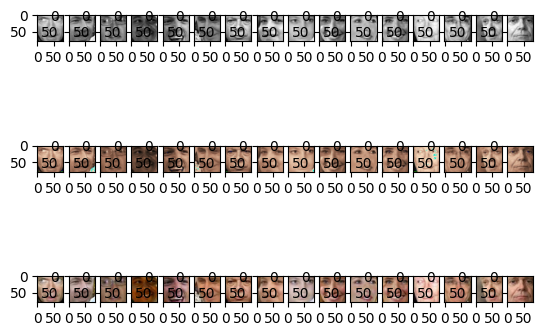

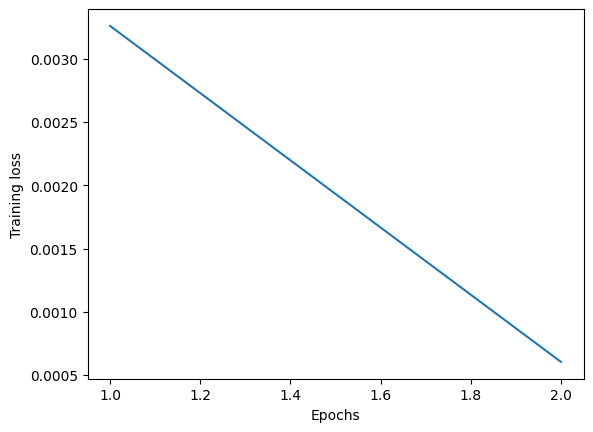

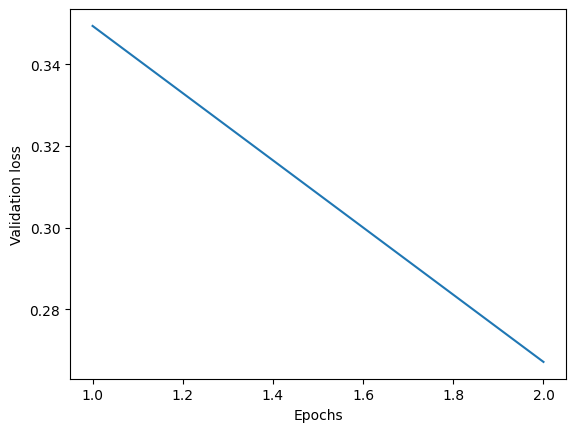

In [2]:
# run the best configuration
best_main(True, True)

In [ ]:
# ---- hyper-parameters ----
# You should tune these hyper-parameters using:
# (i) your reasoning and observations, 
# (ii) by tuning it on the validation set, using the techniques discussed in class.
# You definitely can add more hyper-parameters here.

# --- imports ---
import random
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import hw3utils

torch.multiprocessing.set_start_method('spawn', force=True)
# ---- utility functions -----
def get_loaders(batch_size,device):
    data_root = 'ceng483-f22-hw3-dataset' 
    train_set = hw3utils.HW3ImageFolder(root=os.path.join(data_root,'train'),device=device)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_set = hw3utils.HW3ImageFolder(root=os.path.join(data_root,'val'),device=device)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    test_set = hw3utils.HW3ImageFolder(root=os.path.join(data_root,'test'),device=device)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
    # Note: you may later add test_loader to here.
    return train_loader, val_loader, test_loader

# seeding for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

def get_orig_range(arr):
  return ((arr - (-1)) * (1/2 * 255)).long()

# ---- FurtherNet -----
class BestNet(nn.Module):
    def __init__(self):
        super(BestNet, self).__init__()

        # parameters from the best config as stated above....
        self.n_layers = 2
        self.n_kernels = 4

        # The best config uses batch normalization and 16 intermediate channels
        
        self.conv1_sixt = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2_sixt = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)
        
        self.bn_sixt = nn.BatchNorm2d(num_features=16)
        self.relu = nn.ReLU()

    def forward(self, grayscale_image):
        # apply your network's layers in the following lines:

        x = self.relu(self.bn_sixt(self.conv1_sixt(grayscale_image)))
        x = self.conv2_sixt(x)

        return x

def load_model_eval_images(test=False):
    batch_size = 20
    DEVICE_ID = 'cuda:0' 
    LOG_DIR = 'checkpoints'
    IMG_DIR = 'img'
    TEST_SIZE = 100
    OUTPUT_FILE = 'estimations_test.npy'
    NAME_FILE = 'test_images.txt'

    device = torch.device(DEVICE_ID)
    print('device: ' + str(device))
    net = BestNet().to(device=device) # initialize network with parameters

    _, val_loader, test_loader = get_loaders(batch_size,device)
    net.load_state_dict(torch.load(os.path.join(LOG_DIR,'trained_best_config.pt')))
    # net = torch.load(os.path.join(LOG_DIR,'trained_best_config.pt'))

    net.eval()
    count = 0
    result = []
    all_paths = []
    with torch.no_grad():
      if test:
        loader = test_loader
      else:
        loader = val_loader
      for iteri, data in enumerate(loader, 0):
        if iteri == 5:
          break
        inputs, _, paths = data
        all_paths.extend(paths)
        
        preds = net(inputs)

        # convert prediction to its original range
        _preds = get_orig_range(preds)
        # hw3utils.visualize_batch(inputs,preds,preds,os.path.join(IMG_DIR,f'Test_output{iteri}'))


        # for i in range(batch_size):
        #   hw3utils.save_tensor_as_image(preds[i], os.path.join('test_output_img',f'Test_output{iteri * batch_size + i}'))
        
        for _pred in _preds:
          matrix = []
          red_matrix = _pred[0].cpu()
          green_matrix = _pred[1].cpu()
          blue_matrix = _pred[2].cpu()
          num_of_rows = len(red_matrix)
          num_of_cols = len(red_matrix[0])
          for i in range(num_of_rows):
            row = []
            for j in range(num_of_cols):
              r = red_matrix[i][j]
              g = green_matrix[i][j]
              b = blue_matrix[i][j]
              row.append([r, g, b])
            matrix.append(row)
          result.append(matrix)
          count += 1
      # result = result.cpu()
    # print(type(result))
    # print(result[0:2])
    result = np.array(result)
    print(result.shape)
    np.save(OUTPUT_FILE, result)

    name_file = open(NAME_FILE, 'w')
    for path in all_paths:
      name_file.write(path + '\n')
    name_file.close()



: 

device: cuda:0
torch.Size([20, 3, 80, 80])
torch.Size([20, 3, 80, 80])
torch.Size([20, 3, 80, 80])
torch.Size([20, 3, 80, 80])
torch.Size([20, 3, 80, 80])
(100, 80, 80, 3)


<Figure size 640x480 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

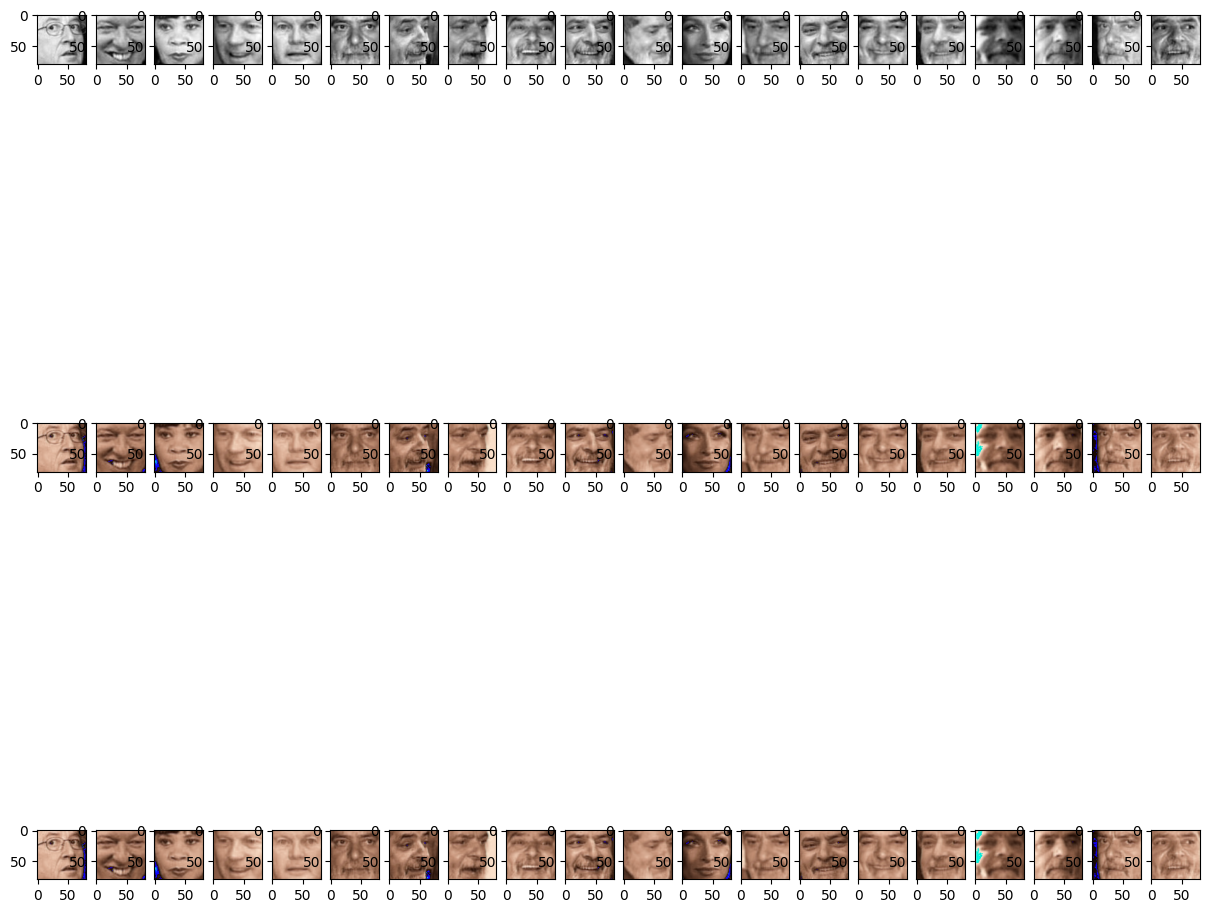

In [2]:
# Run the model on either the test or the validation images
# The argument should be True to generate outputs for the test images
# False for the validation images
load_model_eval_images(test=False)